In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##To remove the text from the images we have to inpaint the Images to remove the text so then we run the Object Detection Algorithm on the Processed Images.

##We can inpaint the image using **keras-ocr**

In [ ]:
!pip install keras-ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 792.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
pipeline=keras_ocr.pipeline.Pipeline()

In [ ]:
import os
import cv2
import numpy as np
import math
import keras_ocr


dataset_directory="/content/drive/MyDrive/Hateful_memes_sizeredu"
output_directory="/content/drive/MyDrive/Processed_Images"


def midpoint(x1,y1,x2,y2):
    x_mid=int((x1+x2)/2)
    y_mid=int((y1+y2)/2)
    return (x_mid,y_mid)

def inpaint_text(images, pipeline):
    processed_images=[]
    for img in images:

        masks=[]
        for _ in range(3):  # 3 channels (R, G, B)
            masks.append(np.zeros(img.shape[:2], dtype="uint8"))
        prediction_groups=pipeline.recognize([img])

        for group in prediction_groups:
            for box in group:
                x0,y0=map(int, box[1][0])
                x1,y1=map(int, box[1][2])
                for i in range(3):
                    masks[i][y0:y1, x0:x1]=255
        inpainted_channels=[]
        for channel, mask in zip(cv2.split(img),masks):
            inpainted_channels.append(cv2.inpaint(channel,mask,7,cv2.INPAINT_NS))

        # Merge inpainted channels to form the final RGB image
        inpainted_img=cv2.merge(inpainted_channels)
        processed_images.append(inpainted_img)
    return processed_images

for filename in os.listdir(dataset_directory):
    if filename.endswith(".png"):
        image_path=os.path.join(dataset_directory,filename)
        img=cv2.imread(image_path)
        processed_img=inpaint_text([img],pipeline)[0]
        output_path=os.path.join(output_directory,filename)
        cv2.imwrite(output_path, processed_img)


##HERE I TRANSFORMED THE IMAGE TO GREYSCALE WHILE INPAINTING AS IT GREATLY REDUCES THE TIME REQUIRED TO PROCESS THE IMAGES.


##ONE ISSUE WITH THIS IS THAT THOUGH THE GENDER CLASSIFICATION ON THE TRANSFORMED IMAGES WERE ALMOST ROUGHLY EQUAL. THE EMOTIONS AND ANIMALS CLASSIFICATION VARIED GREATLY.

##FURTHER RESEARCH LED TO THE CONCLUSION THAT FOR EMOTION AND ANIMALS CLASSIFICATION TO WORK THE BEST THE IMAGES HAVE TO BE COLOR.

##WHEN I RAN THE INPAINT FUNCTION FOR THE COLOR IMAGE DATASET,IT EXECEEDED THE MAX TIME ON THE GPU(ON MULTIPLE TRIES).

##TO TACKLE THIS I HAVE DECIDED  TO PERFORM THE INPAINT ON 25% OF THE IMAGE DATASET(TOOK A ROUND FIGURE OF 3000 IMAGES) AND PERFORM ANALYSIS ON THEM.


##**EACH OF THE CUSTOM YOLOv8 MODELS HAVE BEEN TRAINED USING ANNOTATED DATA AVAILABLE ON ROBOFLOW.**

##OUT OF THE 3 MODELS,
##1.THE GENDER CLASSIFICATION MODEL HAS A PRECISION AND RECALL OF ABOUT 95% FOR BOTH.
##2.THE EMOTIONS CLASSIFCATION MODEL HAS A PRECISION OF ABOUT 80% AND RECALL OF ABOUT 85%.
##3.THE ANIMALS CLASSIFCATION MODEL HAS A PRECISION OF ABOUT 60% AND RECALL OF ABOUT 35%.

##Analysis on Gender

In [7]:
gender=pd.read_csv('/content/drive/MyDrive/rand_3000_gender.csv')
gender

,image_id,gender,prob
0,63952.png,Male,0.98
1,07934.png,Male,0.97
2,38652.png,Male,0.86
3,78429.png,Female,0.78
4,34506.png,Male,0.93
...,...,...,...
2303,19523.png,Male,0.97
2304,46831.png,Female,0.91
2305,59278.png,Male,0.98
2306,39206.png,Male,0.94


In [6]:
gender_inpainted=pd.read_csv('/content/drive/MyDrive/rand_3000_gender_inpaint.csv')
gender_inpainted

,image_id,gender,prob
0,63952.png,Male,0.98
1,07934.png,Male,0.97
2,38652.png,Male,0.90
3,78429.png,Female,0.80
4,29814.png,Female,0.82
...,...,...,...
2248,96123.png,Male,0.90
2249,19523.png,Male,0.97
2250,46831.png,Female,0.97
2251,59278.png,Male,0.98


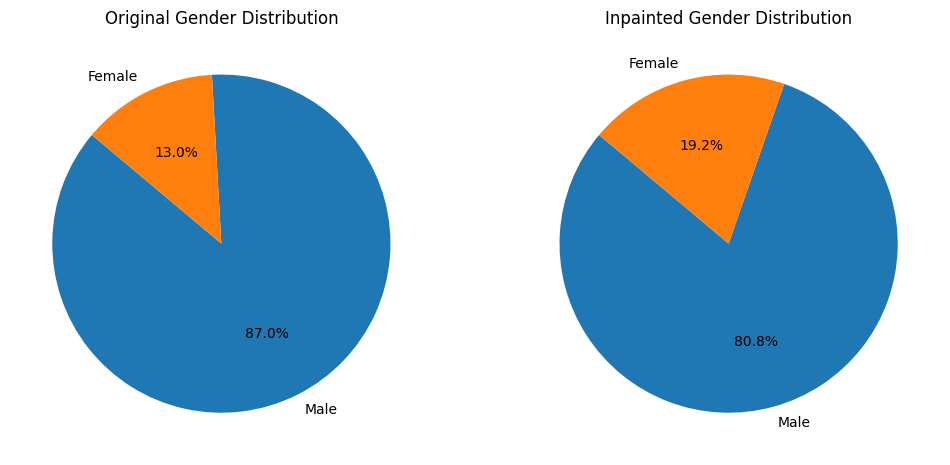

In [20]:
import matplotlib.pyplot as plt

original_gender_counts=gender['gender'].value_counts()
inpainted_gender_counts=gender_inpainted['gender'].value_counts()

fig,axs=plt.subplots(1,2,figsize=(12,6))

axs[0].pie(original_gender_counts, labels=original_gender_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Original Gender Distribution')

axs[1].pie(inpainted_gender_counts, labels=inpainted_gender_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Inpainted Gender Distribution')

plt.show()



In [22]:
merged_data=pd.merge(gender,gender_inpainted,on='image_id',suffixes=('_original', _inpaint'))
merged_data

,image_id,gender_original,prob_original,gender_inpaint,prob_inpaint
0,63952.png,Male,0.98,Male,0.98
1,07934.png,Male,0.97,Male,0.97
2,38652.png,Male,0.86,Male,0.90
3,78429.png,Female,0.78,Female,0.80
4,34506.png,Male,0.93,Male,0.83
...,...,...,...,...,...
2047,96123.png,Male,0.93,Male,0.90
2048,19523.png,Male,0.97,Male,0.97
2049,46831.png,Female,0.91,Female,0.97
2050,59278.png,Male,0.98,Male,0.98


## Here I am creating a boolean mask and filtering the merged dataframe to identify rows where 'gender_original' and 'inpaint_inpaint' values are not the same

In [23]:
mask=merged_data['gender_original']!=merged_data['gender_inpaint']
mismatched_rows=merged_data[mask]

print(mismatched_rows)
total_occurrences=len(mismatched_rows)
print("Total occurrences of mismatched rows:",total_occurrences)

       image_id gender_original  prob_original gender_inpaint  prob_inpaint
43    21853.png          Female           0.86           Male          0.77
166   52746.png            Male           0.84         Female          0.76
201   06415.png            Male           0.98         Female          0.71
206   45286.png          Female           0.84           Male          0.78
210   52490.png            Male           0.92         Female          0.80
...         ...             ...            ...            ...           ...
1858  42903.png            Male           0.77         Female          0.77
1882  43680.png            Male           0.88         Female          0.71
1953  82731.png            Male           0.71         Female          0.75
2002  52316.png            Male           0.81         Female          0.76
2026  01256.png            Male           0.81         Female          0.74

[71 rows x 5 columns]
Total occurrences of mismatched rows: 71


##HERE I AM CHECKING ALL THE EXTRA PREDICTIONS THAT ARE PRESENT IN THE DATAFRAME "GENDER_INPAINT"

In [25]:

extra_predictions=gender_inpainted[~gender_inpainted['image_id'].isin(gender['image_id'])]
print(extra_predictions)


Extra Predictions in gender_inpaint:
       image_id  gender  prob
4     29814.png  Female  0.82
26    90718.png    Male  0.74
41    59487.png  Female  0.79
42    73849.png    Male  0.85
49    45128.png  Female  0.76
...         ...     ...   ...
2228  04819.png  Female  0.90
2235  14573.png  Female  0.89
2236  75840.png    Male  0.97
2237  07651.png  Female  0.95
2246  90564.png    Male  0.82

[207 rows x 3 columns]


In [29]:
desired_row=gender[gender['image_id']=='29814.png']
print(desired_row)

Empty DataFrame
Columns: [image_id, gender, prob]
Index: []


In [30]:
desired_row=gender[gender['image_id']=='90718.png']
print(desired_row)


Empty DataFrame
Columns: [image_id, gender, prob]
Index: []


##In the above 3 cells taking 2 example we can find that through inpainting, the image_id "29814" and  "90718" were able to get the predictions.

##Analysis on Emotion

In [32]:
import pandas as pd
emotion=pd.read_csv('/content/drive/MyDrive/rand_3000_emotion.csv')
emotion.rename(columns={'animal':'emotion'}, inplace=True)
emotion

,image_id,emotion,prob
0,63952.png,surprise,0.75
1,78429.png,surprise,0.88
2,29814.png,surprise,0.73
3,54318.png,surprise,0.96
4,70842.png,surprise,0.71
...,...,...,...
1389,46831.png,surprise,0.93
1390,46831.png,surprise,0.88
1391,72396.png,surprise,0.94
1392,39206.png,surprise,0.74


In [33]:
emotion_inpainted=pd.read_csv('/content/drive/MyDrive/rand_3000_emotions_inpaint.csv')
emotion_inpainted.rename(columns={'animal':'emotion'}, inplace=True)
emotion_inpainted

,image_id,emotion,prob
0,78429.png,surprise,0.86
1,56489.png,sad,0.76
2,29814.png,surprise,0.84
3,54318.png,surprise,0.94
4,34506.png,surprise,0.83
...,...,...,...
1437,46831.png,surprise,0.88
1438,46831.png,surprise,0.87
1439,72396.png,surprise,0.95
1440,39206.png,surprise,0.94


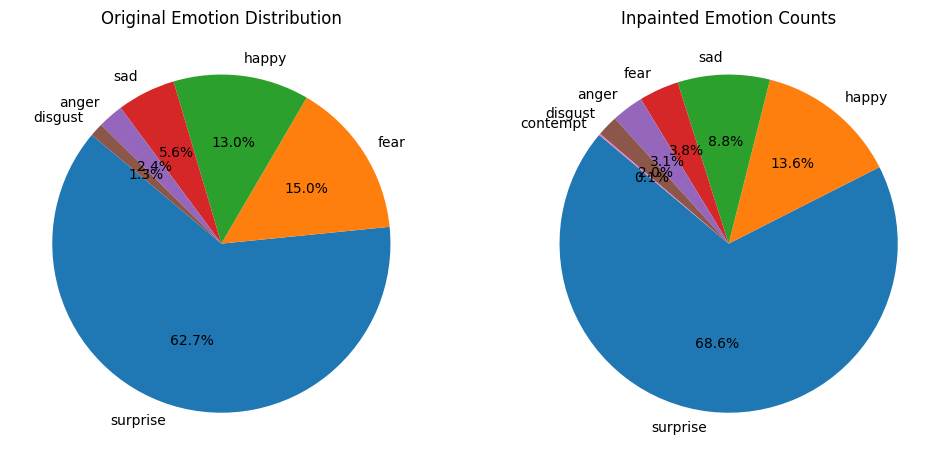

In [35]:
import matplotlib.pyplot as plt

original_emotion_counts=emotion['emotion'].value_counts()
inpainted_emotion_counts=emotion_inpainted['emotion'].value_counts()

fig,axs=plt.subplots(1,2,figsize=(12,6))

axs[0].pie(original_emotion_counts,labels=original_emotion_counts.index,autopct='%1.1f%%',startangle=140)
axs[0].set_title('Original Emotion Distribution')

axs[1].pie(inpainted_emotion_counts,labels=inpainted_emotion_counts.index,autopct='%1.1f%%',startangle=140)
axs[1].set_title('Inpainted Emotion Counts')

plt.show()


In [37]:
merged_data=pd.merge(emotion,emotion_inpainted,on='image_id',suffixes=('_original','_inpaint'))
merged_data

,image_id,emotion_original,prob_original,emotion_inpaint,prob_inpaint
0,78429.png,surprise,0.88,surprise,0.86
1,29814.png,surprise,0.73,surprise,0.84
2,54318.png,surprise,0.96,surprise,0.94
3,27450.png,happy,0.71,surprise,0.95
4,27450.png,happy,0.71,happy,0.71
...,...,...,...,...,...
1390,46831.png,surprise,0.88,surprise,0.88
1391,46831.png,surprise,0.88,surprise,0.87
1392,72396.png,surprise,0.94,surprise,0.95
1393,39206.png,surprise,0.74,surprise,0.94


In [39]:
mask=merged_data['emotion_original']!=merged_data['emotion_inpaint']
mismatched_rows=merged_data[mask]

print(mismatched_rows)
total_occurrences=len(mismatched_rows)
print("Total occurrences of mismatched rows:",total_occurrences)

       image_id emotion_original  prob_original emotion_inpaint  prob_inpaint
3     27450.png            happy           0.71        surprise          0.95
37    98720.png              sad           0.75        surprise          0.89
46    82137.png             fear           0.78             sad          0.74
47    82137.png             fear           0.76             sad          0.74
48    41063.png             fear           0.89        surprise          0.79
...         ...              ...            ...             ...           ...
1367  65240.png             fear           0.73        contempt          0.78
1375  43506.png            happy           0.76        surprise          0.88
1378  43506.png         surprise           0.74           happy          0.77
1381  92613.png          disgust           0.80           happy          0.71
1382  92613.png            happy           0.71         disgust          0.81

[255 rows x 5 columns]
Total occurrences of mismatched rows: 25

In [40]:
extra_predictions=emotion_inpainted[~emotion_inpainted['image_id'].isin(emotion['image_id'])]
print(extra_predictions)


       image_id   emotion  prob
1     56489.png       sad  0.76
4     34506.png  surprise  0.83
9     36508.png  surprise  0.93
10    36508.png      fear  0.72
18    90718.png  surprise  0.92
...         ...       ...   ...
1414  92567.png  surprise  0.79
1420  96143.png  surprise  0.85
1421  43216.png       sad  0.89
1424  23761.png  surprise  0.84
1426  75840.png  surprise  0.80

[351 rows x 3 columns]


##HERE THE POINT TO OBSERVE IS THAT THE MODEL IS INTERCHANGING THE HAPPY AND SURPRISE LABEL.(THIS ACCOUNTS FOR MOST OF THE MISMATCHES)

##Analysis on Animals

In [10]:
animals=pd.read_csv('/content/drive/MyDrive/rand_3000_animal.csv')
animals

,image_id,animal,prob
0,10829.png,Scorpion,0.86
1,53082.png,Cattle,0.94
2,01893.png,Deer,0.80
3,05296.png,Butterfly,0.95
4,05296.png,Butterfly,0.94
...,...,...,...
167,01834.png,Horse,0.92
168,75648.png,Horse,0.82
169,21957.png,Monkey,0.84
170,30462.png,Monkey,0.82


In [11]:
animals_inpainted=pd.read_csv('/content/drive/MyDrive/rand_3000_animal_inpaint.csv')
animals_inpainted

,image_id,animal,prob
0,10829.png,Scorpion,0.87
1,53082.png,Cattle,0.94
2,10536.png,Caterpillar,0.91
3,01893.png,Deer,0.81
4,05296.png,Butterfly,0.95
...,...,...,...
240,01834.png,Horse,0.83
241,40327.png,Crab,0.81
242,75648.png,Horse,0.82
243,30462.png,Monkey,0.81


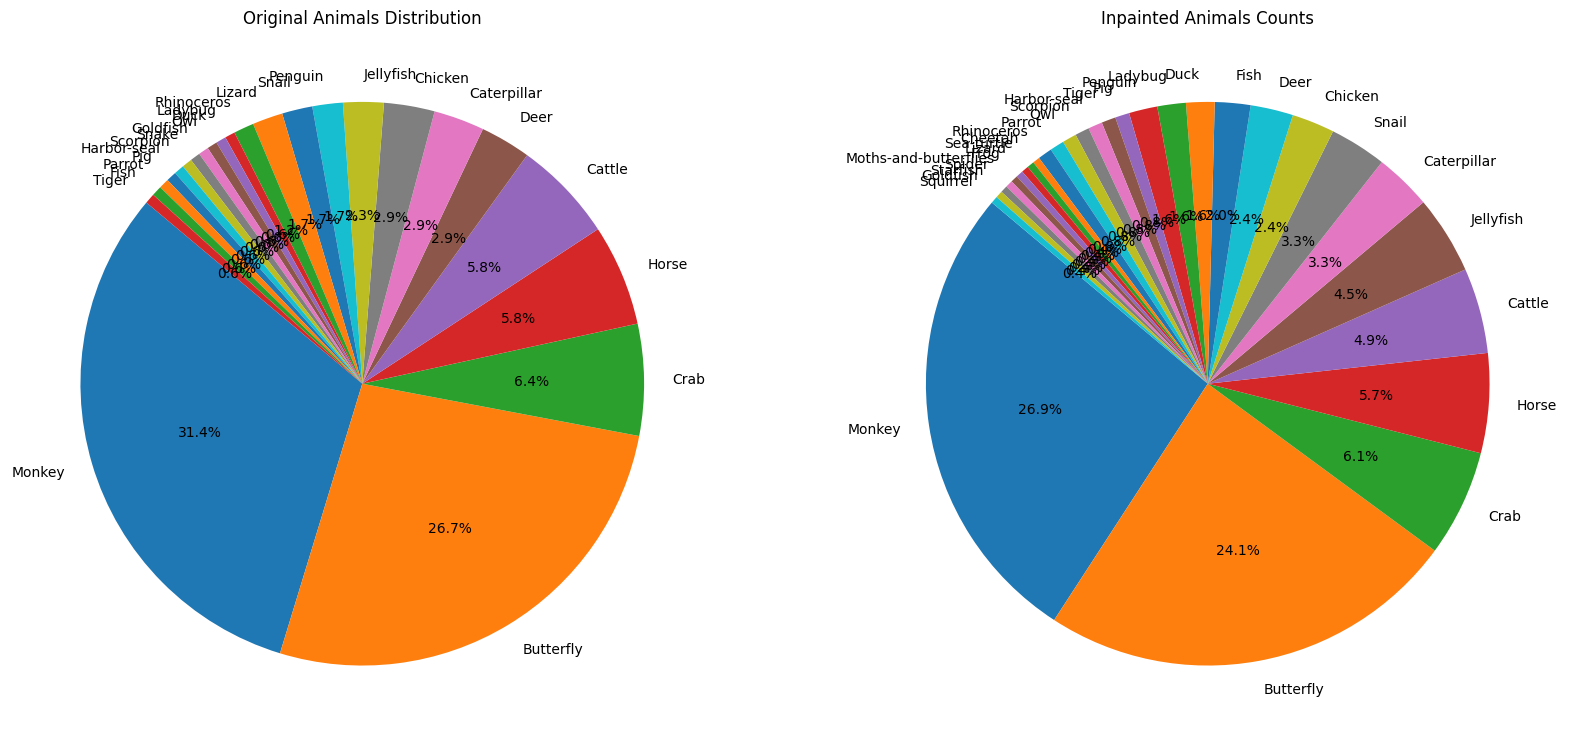

In [42]:
import matplotlib.pyplot as plt

original_animals_counts=animals['animal'].value_counts()
inpainted_animals_counts=animals_inpainted['animal'].value_counts()

fig,axs=plt.subplots(1,2,figsize=(20,20))

axs[0].pie(original_animals_counts,labels=original_animals_counts.index,autopct='%1.1f%%',startangle=140)
axs[0].set_title('Original Animals Distribution')

axs[1].pie(inpainted_animals_counts,labels=inpainted_animals_counts.index,autopct='%1.1f%%',startangle=140)
axs[1].set_title('Inpainted Animals Counts')

plt.show()

In [43]:
merged_data=pd.merge(animals,animals_inpainted,on='image_id',suffixes=('_original','_inpaint'))
merged_data

,image_id,animal_original,prob_original,animal_inpaint,prob_inpaint
0,10829.png,Scorpion,0.86,Scorpion,0.87
1,53082.png,Cattle,0.94,Cattle,0.94
2,01893.png,Deer,0.80,Deer,0.81
3,05296.png,Butterfly,0.95,Butterfly,0.95
4,05296.png,Butterfly,0.95,Butterfly,0.95
...,...,...,...,...,...
406,46759.png,Deer,0.85,Deer,0.90
407,01834.png,Horse,0.92,Horse,0.83
408,75648.png,Horse,0.82,Horse,0.82
409,30462.png,Monkey,0.82,Monkey,0.81


In [46]:
mask=merged_data['animal_original']!=merged_data['animal_inpaint']
mismatched_rows=merged_data[mask]

print(mismatched_rows)
total_occurrences=len(mismatched_rows)
print("Total occurrences of mismatched rows:",total_occurrences)

      image_id animal_original  prob_original animal_inpaint  prob_inpaint
127  87341.png            Crab           0.78       Scorpion          0.83
393  70825.png             Owl           0.80       Squirrel          0.80
Total occurrences of mismatched rows: 2


In [47]:
extra_predictions=animals_inpainted[~animals_inpainted['image_id'].isin(animals['image_id'])]
print(extra_predictions)

      image_id       animal  prob
2    10536.png  Caterpillar  0.91
24   92670.png       Monkey  0.77
27   73506.png   Sea-turtle  0.79
30   89701.png        Snail  0.83
32   06714.png        Snail  0.76
..         ...          ...   ...
229  72945.png         Crab  0.80
231  14879.png       Monkey  0.79
232  14879.png       Cattle  0.77
238  06418.png    Jellyfish  0.79
241  40327.png         Crab  0.81

[76 rows x 3 columns]


##HERE IT IS TO BE NOTED THAT THE PRECISION OF THE PRE TRAINED YOLOv8 MODEL IS 60% AND THE RECALL IS 35%(DESPITE TRAINING THE MODEL MULTIPLE TIMES ON DIFFERENT ROBOLFLOW ANNOTATED MODELS. SO THE DATA CAN BE MISGUIDING